Bibliotecas necesarias

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import floor
import torch as th
from torch import nn

from torch.optim import AdamW
from torch.optim import SGD
from torch.optim import ASGD

# fijamos las semillas de los PRNG por reproducibilidad
np.random.seed(42)
th.manual_seed(42)

##Red de unidades de umbral lineal

Definición de la función escalón

$
\phi(x) = \begin{cases} 1, & \text{si } x \geq 0\\0, & \text{en caso contrario}\end{cases}
$

In [ ]:
def escalon(z):
  if z >= 0.0:
    return 1.0
  else:
    return 0.0

Suma pesada en foma vectorial
$
z = \mathbf{w}^T \mathbf{x} + b
$

In [ ]:
def neurona(x, w, b):
  z = np.dot(w.T, x) + b
  return escalon(z)

XNOR ($\bigodot$)

La siguiente red neuronal es capaz de aproximar la compuerta XNOR, cuya salida es 1 cuando las 2 entradas son iguales:


| $x_1$ | $x_2$ | $y$
| ------------- |:-------------:| -----:|
|0 |0 |1 |
|0 |1 |0 |
|1 |0 |0 |
|1 |1 |1 |

El problema se puede dividir en 3 neuronas, se propone que la primera neurona sea una compuerta AND con entradas $x_1$ y $x_2$, la segunda neurona será una compuerta NOR con entradas $x_1$ y $x_2$, las salidas de ambas neuronas serán las entradas de un compuerta OR.

Las siguientes ecuaciones describen el modelo

$
\hat{y_1} = \phi(w_{11} \cdot x_1 + w_{12} \cdot x_2 + b_1)
$

$
\hat{y_2} = \phi(w_{21} \cdot x_1 + w_{22} \cdot x_2 + b_2)
$

$
\hat{y} = \phi(w_{31} \cdot \hat{y_1} + w_{32} \cdot \hat{y_2} + b_3)
$

Para la compuerta AND se debe tener la siguiente salida

| $x_1$ | $x_2$ | $y_1$
| ------------- |:-------------:| -----:|
|0 |0 |0 |
|0 |1 |0 |
|1 |0 |0 |
|1 |1 |1 |

Para la compuerta NOR se debe tener la siguiente salida

| $x_1$ | $x_2$ | $y_2$
| ------------- |:-------------:| -----:|
|0 |0 |1 |
|0 |1 |0 |
|1 |0 |0 |
|1 |1 |0 |

Para la compuerta OR se debe tener la siguiente salida

| $y_1$ | $y_2$ | $y$
| ------------- |:-------------:| -----:|
|0 |0 |0 |
|0 |1 |1 |
|1 |0 |1 |
|1 |1 |1 |

Para poder simular la compuerta XNOR es necesario encontrar los valores apropiados de $w_{11}$, $w_{21}$, $w_{31}$, $w_{12}$, $w_{22}$, $w_{32}$, $w_{13}$, $w_{23}$, $w_{33}$, $b_1$, $b_2$ y $b_3$.

In [ ]:
X = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]]) #Entradas de la red
w1 = np.array([5, 5]) #Pesos propuestos para la compuerta AND
w2 = np.array([-1, -1])#Pesos propuestos para la compuerta NOR
w3 = np.array([2, 2]) #Pesos propuestos para la compuerta OR
b1 = -9 #Sesgos propuestos para la compuerta AND
b2 = 0.9 #Sesgos propuestos para la compuerta NOR
b3 = -1.5 #Pesos propuestos para la compuerta OR

print('-----------------------')
print('x_1 \tx_2 \ty_hat')
print('-----------------------')
for i in range(X.shape[0]):
  y1 = neurona(X[i, :].T, w1, b1) #salida de la primera neurona en la primera capa
  y2 = neurona(X[i, :].T, w2, b2) #salida de la segunda neurona en la primera capa
  y_hat =neurona(np.array([y1,y2]).T, w3, b3) #salida de la neurona en la segunda capa
  print('{0} \t{1}\t{2}'.format(X[i, 0], X[i, 1], y_hat))

-----------------------
x_1 	x_2 	y_hat
-----------------------
0.0 	0.0	1.0
0.0 	1.0	0.0
1.0 	0.0	0.0
1.0 	1.0	1.0


#Retropropagación en red densa

Funciones de activación sigmoide, relu y sus derivadas que serán usadas en las capas:

-Función ReLu

$$
ReLU(z) = \begin{cases} z, & \text{si } z \geq 0\\0, & \text{en caso contrario}\end{cases}
$$

La derivada de la función ReLU se define como

$$
\frac{\partial ReLU (z)}{\partial z}  = \begin{cases} 1, & \text{si } z \geq 0\\0, & \text{en caso contrario}\end{cases}
$$

-Función sigmoide

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

La función sigmoide tiene una derivada que está expresada en términos de la misma función, esto es,

$$
\frac{\partial \sigma (z)}{\partial z} = \sigma(z) (1 - \sigma(z))
$$

In [ ]:
def sigmoide(z):
  return 1 / (1 + np.exp(-z))

def derivada_sigmoide(x):
  s = sigmoide(x)
  return s * (1.0 - s)

def relu(z):
  z[z<0]=0
  return z

def derivada_relu(x):
  x[x<=0]=0
  x[x>0]=1
  return x

Podemos ver la operación XOR como una tarea de clasificación binaria a partir de 2 entradas. Por lo tanto, usaremos la función de pérdida de entropía cruzada binaria:


$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

In [ ]:
def entropia_cruzada_binaria(y, p):
  p[p == 0] = np.nextafter(0., 1.)
  p[p == 1] = np.nextafter(1., 0.)
  return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

Exactitud para medir el rendimiento del modelo aprendido por la red neuronal densa:

$$
exactitud = \frac{correctos}{total}
$$

In [ ]:
def exactitud(y, y_predicha):
  return (y == y_predicha).mean() * 100

Ahora, definimos la función que propaga hacia adelante una entrada $\mathbf{X} \in \mathbb{R}^{m \times d}$. Como la red está compuesta de 3 capas densas (2 ocultas y 1 de salida), tenemos 3 matrices de pesos con sus correspondientes vectores de sesgos $\{\mathbf{W}^{\{1\}} \in \mathbb{R}^{d \times l}, \mathbf{b}^{\{1\}} \in \mathbb{R}^{l \times 1}\}$, $\{\mathbf{W}^{\{2\}} \in \mathbb{R}^{l \times k}, \mathbf{b}^{\{2\}} \in \mathbb{R}^{k \times 1}\}$ y $\{\mathbf{W}^{\{3\}} \in \mathbb{R}^{k \times p}, \mathbf{b}^{\{3\}} \in \mathbb{R}^{p \times 1}\}$ de la capa oculta y la capa de salida respectivamente. Así, podemos llevar a cabo la propagación hacia adelante en esta red de la siguiente manera:

$$
	\begin{split}
				\mathbf{A}^{\{1\}} & =  \mathbf{X} \\
				\mathbf{Z}^{\{2\}} & =  \mathbf{A}^{\{1\}} \cdot \mathbf{W}^{\{1\}} + \mathbf{b}^{\{1\}}\\
				\mathbf{A}^{\{2\}} & =  \sigma(\mathbf{Z}^{\{2\}}) \\
				\mathbf{Z}^{\{3\}} & =  \mathbf{A}^{\{2\}} \mathbf{W}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
				\mathbf{A}^{\{3\}} & =  \sigma(\mathbf{Z}^{\{3\}})\\
        \mathbf{Z}^{\{4\}} & =  \mathbf{A}^{\{3\}} \mathbf{W}^{\{3\}}  + \mathbf{b}^{\{3\}}\\
        \mathbf{A}^{\{4\}} & =  \sigma(\mathbf{Z}^{\{4\}})\\
				\mathbf{\hat{y}} & =  \mathbf{A}^{\{4\}}
		\end{split}
  $$

In [ ]:
def hacia_adelante(X, W1, b1, W2, b2, W3, b3):
  Z2 = X @ W1 + b1
  A2 = relu(Z2) ##Activación relu
  Z3 = A2 @ W2 + b2
  A3 = relu(Z3) ##Activación relu
  Z4 = A3 @ W3 + b3
  y_hat = sigmoide(Z4) ##Activación sigmoide
  return Z2, A2, Z3, A3, Z4, y_hat

Para facilitar el entrenamiento definimos una función que ordene aleatoriamente y vaya generando lotes del conjunto completo.

In [ ]:
def genera_lotes(X, y, t_lote=16):
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  perm = np.random.permutation(X.shape[0]) # se genera una permutación aleatoria
  Xperm = X[perm] # se reordenan las entradas y
  yperm = y[perm] # las entradas usando la permutación
  for lote in range(n_lotes): # se van tomando t_lote entradas y salidas
    Xlote = Xperm[lote * t_lote:(lote + 1) * t_lote]
    ylote = yperm[lote * t_lote:(lote + 1) * t_lote]
    yield Xlote, ylote

Finalmente, definimos la función para entrenar nuestra red neuronal usando descenso por gradiente. Para calcular el gradiente de la función de pérdida respecto a los pesos y sesgos en cada capa empleamos el algoritmo de retropropagación. Para nuestro caso, serían las siguientes expresiones:

$$
	\begin{split}
				\boldsymbol{\delta}^{\{4\}} & =  \mathbf{\hat{y}}^{(i)} - \mathbf{y}^{(i)}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{3\}}} & =  \mathbf{A}^{\{3\}\top} \cdot \boldsymbol{\delta}^{\{4\}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{3\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{4\}}_{j, :}\\
        \boldsymbol{\delta}^{\{3\}} & =  (\boldsymbol{\delta}^{\{4\}}\cdot \mathbf{W}^{\{3\}\top}) \odot \frac{\partial \mathbf{A}^{\{3\}}}{\partial \mathbf{Z}^{\{3\}}}\\
				\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{2\}}} & =  \mathbf{A}^{\{2\}\top} \cdot \boldsymbol{\delta}^{\{3\}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{2\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{3\}}_{j, :}\\
        \boldsymbol{\delta}^{\{2\}} & =  (\boldsymbol{\delta}^{\{3\}}\cdot \mathbf{W}^{\{2\}\top}) \odot \frac{\partial \mathbf{A}^{\{2\}}}{\partial \mathbf{Z}^{\{2\}}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{1\}}} & =  \mathbf{A}^{\{1\}\top} \cdot \boldsymbol{\delta}^{\{2\}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{1\}}} & =  \sum_{j=1}^{l}\boldsymbol{\delta}^{\{2\}}_{j, :}\\
		\end{split}
  $$

In [ ]:
def retropropagacion(X, y, alpha = 0.01, t_lote=16, n_epocas = 100, n_ocultas_1 = 10, n_ocultas_2=5):
  n_ejemplos = X.shape[0]
  n_entradas = X.shape[1]
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  # Inicialización de las matrices de pesos W y B
  W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas_1)
  b1 = np.zeros((1, n_ocultas_1))

  W2 = np.sqrt(1.0 / n_ocultas_1)* np.random.randn(n_ocultas_1, n_ocultas_2)
  b2 = np.zeros((1, n_ocultas_2))

  W3 = np.sqrt(1.0 / n_ocultas_2)* np.random.randn(n_ocultas_2, 1)
  b3 = np.zeros((1, 1))

  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_predicha = np.zeros((y.shape))
  for i in range(n_epocas):
    for Xlote,ylote in genera_lotes(X, y, t_lote=t_lote):
      Z2, A2, Z3, A3, Z4, y_hat = hacia_adelante(Xlote, W1, b1, W2, b2, W3, b3)

      # cálculo de gradientes para W3 y b3 por retropropagación
      dZ4 = y_hat - ylote
      dW3 = A3.T @ dZ4
      db3 = dZ4.sum(axis=0)

      # cálculo de gradientes para W2 y b2 por retropropagación
      dZ3 = (dZ4 @ W3.T) * derivada_relu(Z3)
      dW2 = A2.T @ dZ3
      db2 = dZ3.sum(axis=0)

      # cálculo de gradientes para W2 y b2 por retropropagación
      dZ2 = (dZ3 @ W2.T) * derivada_relu(Z2)
      dW1 = Xlote.T @ dZ2
      db1 = dZ2.sum(axis=0)

      ####################################
      # IMPORTANTE
      # la actualización de los parámetros
      # debe hacerse de forma simultánea
      W3 -= alpha * dW3
      b3 -= alpha * db3
      W2 -= alpha * dW2
      b2 -= alpha * db2
      W1 -= alpha * dW1
      b1 -= alpha * db1

      # calcula la pérdida en la época
      perdidas[i] += entropia_cruzada_binaria(ylote, y_hat)
      exactitudes[i] += exactitud(ylote, np.round(y_hat))

    perdidas[i] /= n_lotes
    exactitudes[i] /= n_lotes
    print(f'Epoch {i}: Pérdida = {perdidas[i]} Exactitud = {exactitudes[i]}')

  return W1, b1, W2, b2, W3, b3, perdidas, exactitudes

Para probar nuestra red, generamos los ejemplos correspondientes a la operación XOR.

Finalmente, se entrena la red con estos ejemplos por 30 épocas usando una tasa de aprendizaje $\alpha = 0.5$.

In [ ]:
# ejemplo (XOR)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0, 1, 1, 0]]).T

np.random.seed(41)
W1, b1, W2, b2, W3, b3, perdidas, exactitudes = retropropagacion(X,
                                                         y,
                                                         alpha = 0.5,
                                                         n_epocas = 30,
                                                         n_ocultas_1 = 20,
                                                         n_ocultas_2 = 20,
                                                         t_lote=1)

Epoch 0: Pérdida = 0.8829184325690915 Exactitud = 0.0
Epoch 1: Pérdida = 0.7226623540984319 Exactitud = 50.0
Epoch 2: Pérdida = 0.6185151035441085 Exactitud = 50.0
Epoch 3: Pérdida = 0.5373434010641096 Exactitud = 75.0
Epoch 4: Pérdida = 0.34905888617896547 Exactitud = 75.0
Epoch 5: Pérdida = 0.32506188626449173 Exactitud = 100.0
Epoch 6: Pérdida = 0.3447628289562742 Exactitud = 75.0
Epoch 7: Pérdida = 0.701166737601415 Exactitud = 75.0
Epoch 8: Pérdida = 0.19508784422673695 Exactitud = 100.0
Epoch 9: Pérdida = 0.07553880374184113 Exactitud = 100.0
Epoch 10: Pérdida = 0.04468108825019161 Exactitud = 100.0
Epoch 11: Pérdida = 0.029491735430787088 Exactitud = 100.0
Epoch 12: Pérdida = 0.02142232658046485 Exactitud = 100.0
Epoch 13: Pérdida = 0.0166800236938332 Exactitud = 100.0
Epoch 14: Pérdida = 0.013614134792274026 Exactitud = 100.0
Epoch 15: Pérdida = 0.011372431351211435 Exactitud = 100.0
Epoch 16: Pérdida = 0.009746593748073256 Exactitud = 100.0
Epoch 17: Pérdida = 0.00851034607932

Graficamos el valor de la pérdida y la exactitud en cada época para ver el comportamiento de nuestra red durante el entrenamiento:

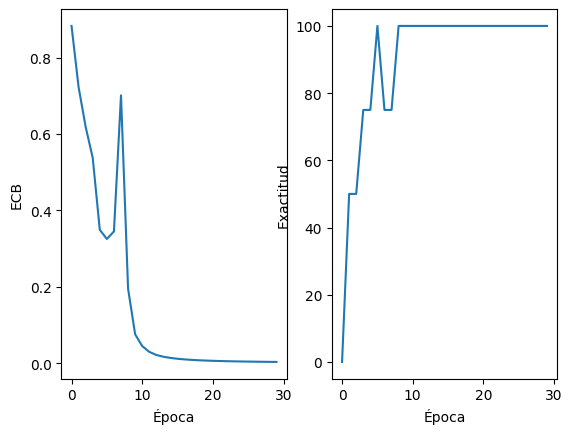

In [ ]:
fig, axs=plt.subplots(nrows=1, ncols=2)
axs[0].plot(np.arange(perdidas.size), perdidas)
axs[0].set_xlabel('Época')
axs[0].set_ylabel('ECB')

axs[1].plot(np.arange(exactitudes.size), exactitudes)
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')

plt.show()

#Redes densas con Pytorch

Usaremos el conjunto de datos de regresión Diabetes Dataset que se puede obtener con scikit-learn. Este conjunto de datos está compuesto por 442 ejemplos con 10 atributos numéricos y una variable de respuesta.

El siguiente paso es dividir este conjunto en subconjuntos de entrenamiento, validación y prueba usando la función `train_test_split` de scikit-learn.

In [ ]:
from sklearn.datasets import load_diabetes

db = load_diabetes(return_X_y=False, as_frame=True)

from sklearn.model_selection import train_test_split

X_ent, X_prueba, y_ent, y_prueba = train_test_split(db['data'].to_numpy(),
                                                    db['target'].to_numpy(),
                                                    test_size = 0.3,
                                                    shuffle=True,
                                                    random_state=42)
X_ent, X_val, y_ent, y_val = train_test_split(X_ent,
                                              y_ent,
                                              test_size = 0.2,
                                              shuffle=True,
                                              random_state=42)

Estandarizamos los valores de los atributos:

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_ent)

X_ent = sc.transform(X_ent)
X_val = sc.transform(X_val)
X_prueba = sc.transform(X_prueba)

Convertimos los subconjuntos de arreglos de NumPy a instancias de `Tensor` de PyTorch y los cargamos al GPU (si está disponible). Para evitar errores de tipos de datos distintos de los operandos, es importante asegurarse de que coincidan. En esta libreta vamos a trabajar con enteros de 32 bits, por lo que lo especificamos en la función `tensor`.

In [ ]:
disp = 'cuda:0' if th.cuda.is_available() else 'cpu'

X_ent = th.tensor(X_ent, dtype = th.float32, device = disp)
X_val = th.tensor(X_val, dtype = th.float32, device = disp)
X_prueba = th.tensor(X_prueba, dtype = th.float32, device = disp)

y_ent = th.tensor(y_ent,  dtype = th.float32, device = disp)
y_val = th.tensor(y_val,  dtype = th.float32, device = disp)
y_prueba = th.tensor(y_prueba, dtype = th.float32,  device = disp)

print(f'Forma de X_ent = {X_ent.shape}, y_ent = {y_ent.shape}')
print(f'Forma de X_val = {X_val.shape}, y_val = {y_val.shape}')
print(f'Forma de X_prueba = {X_prueba.shape}, y_prueba = {y_prueba.shape}')

Forma de X_ent = torch.Size([247, 10]), y_ent = torch.Size([247])
Forma de X_val = torch.Size([62, 10]), y_val = torch.Size([62])
Forma de X_prueba = torch.Size([133, 10]), y_prueba = torch.Size([133])


También es importante asegurarse de que las formas de los tensores de las predicciones (`y_hat`) y de los salidas reales (`y`) sean iguales. Aquí vamos a presuponer que son vectores columnas de $n \times 1$, por lo que cambiamos de forma.

In [ ]:
y_ent = y_ent.reshape((y_ent.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_prueba = y_prueba.reshape((y_prueba.shape[0], 1))
print(f'Forma de y_ent = {y_ent.shape}, y_val = {y_val.shape} y_prueba = {y_prueba.shape}')

Forma de y_ent = torch.Size([247, 1]), y_val = torch.Size([62, 1]) y_prueba = torch.Size([133, 1])


Creamos nuestro cargador de datos a partir de los tensores mediante la clase `TensorDataset`.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

entdl = DataLoader(TensorDataset(X_ent, y_ent),
                   batch_size=16,
                   shuffle=True,
                   drop_last=True)
valdl = DataLoader(TensorDataset(X_val, y_val),
                   batch_size=16,
                   shuffle=False,
                   drop_last=False)
pruebadl = DataLoader(TensorDataset(X_prueba, y_prueba),
                      batch_size=1,
                      shuffle=False,
                      drop_last=False)

Para definir una nueva capa, un nuevo bloque o una red debemos crear una subclase de `Module` y especificar como mínimo los métodos:
- `__init__`, que es el constructor de la subclase y en el cual se tiene que llamar al constructor de la clase base `Module` mediante la función `super` de Python.
- `forward`, que define lo que se ejecuta al llamar al operador paréntesis en una instancia de dicha clase.

Se define una `Red 1` con 3 capas ocultas y funciones de activación $tanh(x)$

In [ ]:
##Activación tanh, 3 capas ocultas
class Red1(nn.Module):
  def __init__(self, d_ent, capa_1, capa_2, capa_3,d_sal):
    super(Red1, self).__init__()
    self.c1 = nn.Linear(d_ent, capa_1)
    self.c2 = nn.Linear(capa_1, capa_2)
    self.c3 = nn.Linear(capa_2, capa_3)
    self.salida = nn.Linear(capa_3, d_sal)

  def forward(self, x):
    x = nn.functional.tanh(self.c1(x)) #Activaciones tanh
    x = nn.functional.tanh(self.c2(x))
    x = nn.functional.tanh(self.c3(x))
    return self.salida(x)

Se define una `Red 1 normal` con 3 capas ocultas, funciones de activación $tanh(x)$ y a la salida de cada función de activación se encuentra una capa de normalización

In [ ]:
##Activación tanh, 3 capas ocultas
##Se aplican capas de normalización
class Red1_normal(nn.Module):
  def __init__(self, d_ent, capa_1, capa_2, capa_3,d_sal):
    super(Red1_normal, self).__init__()
    self.c1 = nn.Linear(d_ent, capa_1) #Capa densa
    self.b1 = nn.LayerNorm(capa_1) #Capa de normalización
    self.c2 = nn.Linear(capa_1, capa_2) #Capa densa
    self.b2 = nn.LayerNorm(capa_2) #Capa de normalización
    self.c3 = nn.Linear(capa_2, capa_3) #Capa densa
    self.b3 = nn.LayerNorm(capa_3) #Capa de normalización
    self.salida = nn.Linear(capa_3, d_sal)

  def forward(self, x):
    x = nn.functional.tanh(self.c1(x)) #Activaciones tanh
    x = self.b1(x)
    x = nn.functional.tanh(self.c2(x))
    x = self.b2(x)
    x = nn.functional.tanh(self.c3(x))
    x = self.b3(x)
    return self.salida(x)

Se define una `Red 1 drop` con 3 capas ocultas, funciones de activación $tanh(x)$ y a la salida de cada función de activación se encuentra una capa de Dropout

In [ ]:
##Activación tanh, 3 capas ocultas
##Se aplican capas de dropout
class Red1_drop(nn.Module):
  def __init__(self, d_ent, capa_1, capa_2, capa_3,d_sal):
    super(Red1_drop, self).__init__()
    self.c1 = nn.Linear(d_ent, capa_1) #Capa densa
    self.d1 = nn.Dropout(p=0.5) #Capa de dropout
    self.c2 = nn.Linear(capa_1, capa_2) #Capa densa
    self.d2 = nn.Dropout(p=0.5) #Capa de dropout
    self.c3 = nn.Linear(capa_2, capa_3) #Capa densa
    self.d3 = nn.Dropout(p=0.5) #Capa de dropout
    self.salida = nn.Linear(capa_3, d_sal)

  def forward(self, x):
    x = nn.functional.tanh(self.c1(x)) #Activaciones tanh
    x = self.d1(x)
    x = nn.functional.tanh(self.c2(x))
    x = self.d2(x)
    x = nn.functional.tanh(self.c3(x))
    x = self.d3(x)
    return self.salida(x)

Se define una `Red 1 drop` con 3 capas ocultas, funciones de activación $tanh(x)$, a la salida de cada función de activación se encuentra una capa de normalización y a la salida de esta se encuentra una capa de Dropout

In [ ]:
##Activación tanh, 3 capas ocultas
##Se aplican capas de dropout y normalización
class Red1_drop_normal(nn.Module):
  def __init__(self, d_ent, capa_1, capa_2, capa_3,d_sal):
    super(Red1_drop_normal, self).__init__()
    self.c1 = nn.Linear(d_ent, capa_1) #Capa densa
    self.b1 = nn.LayerNorm(capa_1) #Capa de normalización
    self.d1 = nn.Dropout(p=0.5) #Capa de normalización

    self.c2 = nn.Linear(capa_1, capa_2) #Capa densa
    self.b2 = nn.LayerNorm(capa_2) #Capa de normalización
    self.d2 = nn.Dropout(p=0.5) #Capa de normalización

    self.c3 = nn.Linear(capa_2, capa_3) #Capa densa
    self.b3 = nn.LayerNorm(capa_3) #Capa de normalización
    self.d3 = nn.Dropout(p=0.5) #Capa de normalización
    self.salida = nn.Linear(capa_3, d_sal)

  def forward(self, x):
    x = nn.functional.tanh(self.c1(x)) #Activaciones tanh
    x = self.b1(x)
    x = self.d1(x)
    x = nn.functional.tanh(self.c2(x))
    x = self.b2(x)
    x = self.d2(x)
    x = nn.functional.tanh(self.c3(x))
    x = self.b3(x)
    x = self.d3(x)
    return self.salida(x)

Se define una `Red 2` con 4 capas ocultas, funciones de activación `LeakyReLU`, `Softplus` y `Sigmoide` a la salida de cada función de activación se encuentra una capa de normalización y a la salida de esta se encuentra una capa de Dropout

In [ ]:
#4 capas ocultas, activaciones leaky relu y softplus,
#se usa Dropout y normalización
class Red2(nn.Module):
  def __init__(self, d_ent, capa_1, capa_2, capa_3, capa_4, d_sal):
    super(Red2, self).__init__()
    self.c1 = nn.Linear(d_ent, capa_1) ##Capa densa
    self.b1 = nn.LayerNorm(capa_1) ##Capa de normalización
    self.d1 = nn.Dropout(p=0.5) #Capa de dropout

    self.c2 = nn.Linear(capa_1, capa_2)
    self.b2 = nn.LayerNorm(capa_2)
    self.d2 = nn.Dropout(p=0.5)

    self.c3 = nn.Linear(capa_2, capa_3)
    self.b3 = nn.LayerNorm(capa_3)
    self.d3 = nn.Dropout(p=0.5)

    self.c4 = nn.Linear(capa_3, capa_4)
    self.b4 = nn.LayerNorm(capa_4)
    self.d4 = nn.Dropout(p=0.5)

    self.salida = nn.Linear(capa_4, d_sal)

  def forward(self, x):
    x = nn.functional.leaky_relu(self.c1(x)) #activación leaky relu
    x = self.b1(x)
    x = self.d1(x)
    x = nn.functional.softplus(self.c2(x)) #activación softplus
    x = self.b2(x)
    x = self.d2(x)
    x = nn.functional.leaky_relu(self.c3(x)) #activación leaky relu
    x = self.b3(x)
    x = self.d3(x)
    x = nn.functional.sigmoid(self.c4(x)) #activación softplus
    x = self.b4(x)
    x = self.d4(x)
    return self.salida(x)

Para facilitar el entrenamiento de los modelos vamos a definir una función para un paso de entrenamiento, a la cual llamaremos `paso_ent`. Esta función recibe como argumento:
- El modelo como una instancia de `Module` (`modelo`).
- La función de pérdida (`fp`).
- Una instancia de `Optimizer` del módulo `optim` de PyTorch para actualizar los pesos y sesgos (`opt`).
- Una instancia de `Tensor` con el lote de entradas (`X`).
- Una instancia de `Tensor` con el lote de salidas (`y`).

La función obtiene las predicciones del modelo para las entradas, calcula la pérdida, obtiene los gradientes y actualiza todos los parámetros del modelo mediante descenso por gradiente.

In [ ]:
def paso_ent(modelo, fp, opt, X, y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                  # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with th.no_grad():
    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
  return perdida_paso

También definimos una función para el ciclo de entrenamiento principal, que llamaremos `entrena`. Esta función recibe como argumentos:
- El modelo como una instancia de `Module` (`modelo`).
- La función de pérdida (`fp`).
- La métrica de evaluación (`metrica`).
- Una instancia de `Optimizer` del módulo `optim` de PyTorch para actualizar los pesos y sesgos (`opt`).
- El cargador de datos del subconjunto de entrenamiento (`entdl`).
- El cargador de datos del subconjunto de validación (`valdl`).
- El número de épocas de entrenamiento (`n_epocas`).

Para cada una de las épocas, va tomando un lote de entradas y salidas a la vez, con los cuales se realiza un paso de entrenamiento.

In [ ]:
def entrena(modelo, fp, metrica, opt, entdl, valdl, n_epocas = 100):
  hist = {'perdida_ent': np.zeros(n_epocas, dtype = np.float32),
          'perdida_val': np.zeros(n_epocas, dtype = np.float32)}
  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for lote, (Xlote, ylote) in enumerate(entdl):
      hist['perdida_ent'][e] += paso_ent(modelo, fp, opt, Xlote, ylote)

    # bucle de evaluación
    modelo.eval()
    for (Xlote, ylote) in valdl:
      with th.no_grad():
        y_pred = modelo(Xlote)
        hist['perdida_val'][e] += metrica(y_pred, ylote).cpu().numpy()

  return hist

Se crea una función para disminuir las líneas de código al graficar, como entrada se tiene el histograma de entrenamiento y validación, los dataloader de entrada y valicación y un string que se agrega a las etiquetas de las gráficas para diferenciar las redes y comparar de forma sencilla

In [ ]:
def graficar(hist, entdl, valdl, opt): ##Función para graficar y ahorrar líneas de código
  plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento '+opt)
  plt.plot(hist['perdida_val'] / len(valdl), label='Validación '+opt)
  plt.xlabel('Época')
  plt.ylabel('Pérdida')
  plt.legend()
  #plt.show()

A continuación se observan gráficas producidas por la función d pérdida en redes neuronales cuya arquitectura es la misma, pero las funciones de optmización son diferentes, en la primera se tiene `SGD` y en la segunda se tiene `AdamW`. Se observa que el método `AdamW` permite un mayor `Learning Rate`.

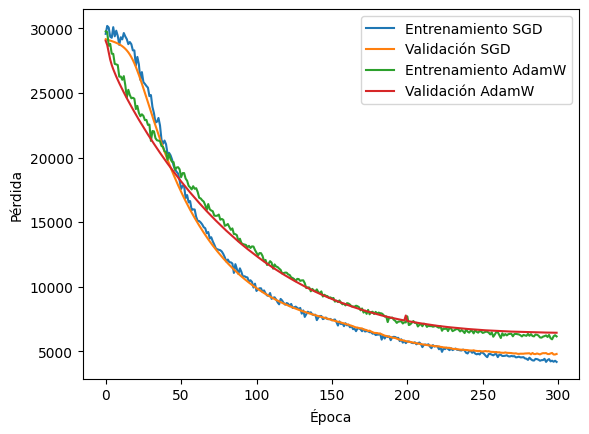

In [ ]:
#Optimizador SGD
mired = Red1(X_ent.shape[-1], 25, 25, 25,1) ##Activación tanh, 3 capas ocultas
mired.to(disp)
ecm = nn.MSELoss()
opt1 = SGD(mired.parameters(), lr = 14e-6)
hist = entrena(mired, ecm, nn.functional.mse_loss, opt1, entdl, valdl, n_epocas=300)
graficar(hist, entdl, valdl, "SGD")

#Optimizador AdamW
mired = Red1(X_ent.shape[-1], 25, 25, 25,1) ##Activación tanh, 3 capas ocultas
mired.to(disp)
opt2 = AdamW(mired.parameters(), lr = 20e-4)
hist = entrena(mired, ecm, nn.functional.mse_loss, opt2, entdl, valdl, n_epocas=300)
graficar(hist, entdl, valdl, "AdamW")

plt.show()

En el siguiente gráfica se observa la función de pérdida en redes neuronales cuya arquitectura es la similar, pero en una arquitectura se tienen capas de Dropout y en la otra no, ambas redes utilizan `SGD` como optimizador y el mismo `Learning Rate`.

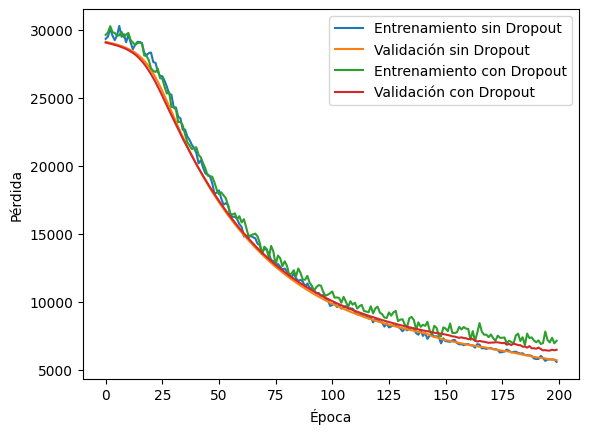

In [ ]:
#Optimizador SGD
mired = Red1(X_ent.shape[-1], 25, 25, 25,1)
mired.to(disp) ##Activación tanh, 3 capas ocultas y capas de normalización

ecm = nn.MSELoss()
opt = SGD(mired.parameters(), lr = 14e-6) #14e-6

hist = entrena(mired, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=200)
graficar(hist, entdl, valdl, "sin Dropout")

mired = Red1_drop(X_ent.shape[-1], 25, 25, 25,1) ##Activación tanh, 3 capas ocultas
mired.to(disp)
opt = SGD(mired.parameters(), lr = 14e-6) #14e-6
hist = entrena(mired, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=200)
graficar(hist, entdl, valdl, "con Dropout")

plt.show()

La gráfica siguiente muestra la función de pérdida de redes neuronales cuya arquitectura es similar, pero en una arquitectura se tienen capas de normalización y en la otra no, ambas redes utilizan `SGD` como optimizador y el mismo `Learning Rate`.

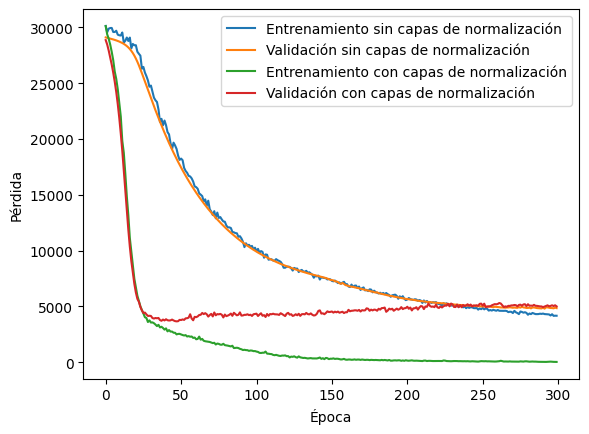

In [ ]:
#Optimizador SGD
mired = Red1(X_ent.shape[-1], 25, 25, 25,1)
mired.to(disp) ##Activación tanh, 3 capas ocultas y capas de normalización

ecm = nn.MSELoss()
opt = SGD(mired.parameters(), lr = 14e-6) #14e-6

hist = entrena(mired, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=300)
graficar(hist, entdl, valdl,"sin capas de normalización")

mired = Red1_normal(X_ent.shape[-1], 25, 25, 25,1) ##Activación tanh, 3 capas ocultas
mired.to(disp)
opt = SGD(mired.parameters(), lr = 14e-6) #14e-6
hist = entrena(mired, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=300)
graficar(hist, entdl,valdl, "con capas de normalización")

plt.show()

Se muestran la gráficas que se obtienen con funciones de pérdida en redes neuronales cuya arquitectura es similar, pero en una arquitectura se tienen capas de normalización y en la otra no, ambas redes utilizan `SGD` como optimizador y el mismo `Learning Rate`.

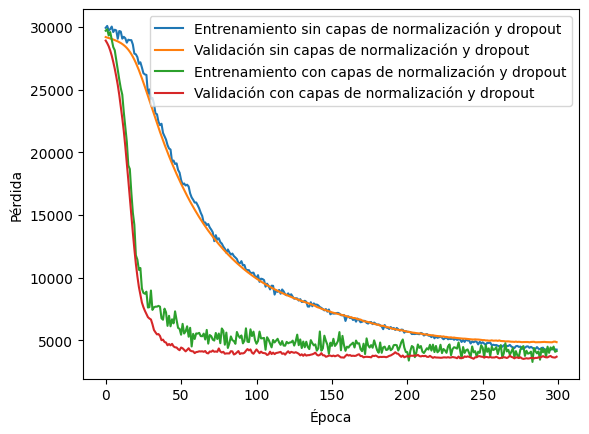

In [ ]:
#Optimizador SGD
mired = Red1(X_ent.shape[-1], 25, 25, 25,1)
mired.to(disp)
##Activación tanh, 3 capas ocultas, capas de normalización y dropout

ecm = nn.MSELoss()
opt = SGD(mired.parameters(), lr = 14e-6) #14e-6

hist = entrena(mired, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=300)
graficar(hist, entdl, valdl,"sin capas de normalización y dropout")

mired = Red1_drop_normal(X_ent.shape[-1], 25, 25, 25,1) ##Activación tanh, 3 capas ocultas
mired.to(disp)
opt = SGD(mired.parameters(), lr = 14e-6) #14e-6
hist = entrena(mired, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=300)
graficar(hist, entdl, valdl,"con capas de normalización y dropout")

plt.show()

Por último se compara una red con 4 capas ocultas y una con 3 capas ocultas, se usa la misma función para optimizar y el mismo learning rate, las funciones de activación son diferentes en cada red.

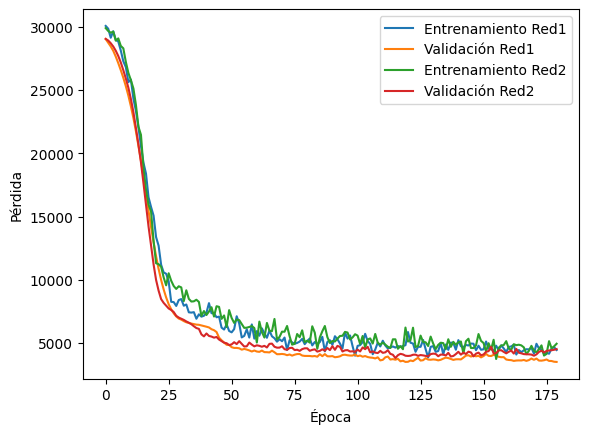

In [ ]:
mired = Red1_drop_normal(X_ent.shape[-1], 25, 25, 25,1) ##Activación tanh, 3 capas ocultas
mired.to(disp)
ecm = nn.MSELoss()
opt = SGD(mired.parameters(), lr = 14e-6) #14e-6
hist = entrena(mired, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=180)
graficar(hist, entdl, valdl,"Red1")

mired = Red2(X_ent.shape[-1], 25, 25, 25, 25, 1)
mired.to(disp)
#4 capas ocultas, activaciones leaky_relu, softplus y sigmoid
#se usa Dropout, capas Norm
ecm = nn.MSELoss()
opt = ASGD(mired.parameters(), lr = 14e-6)
hist = entrena(mired, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=180)

graficar(hist, entdl , valdl,"Red2")
plt.show()

# Análisis de resultados

En la primera parte se logró obtener una compuerta XNOR definiendo una red neuronal de 2 capas y pesos de forma manual, con esto se observa que los pesos y sesgos pueden ser diferentes para una misma compuerta, por otro lado también existen varias combinaciones de compuertas lógicas que aproximan a la compuerta XNOR por lo que existen muchas soluciones.


En la segunda parte se utilizaron funciones no lineales como funciones de activación en las neuronas artificiales, además se utilizó el algoritmo Backpropagation para encontrar una solución a la compuerta XOR, al ser una tarea sencilla en menos de 50 épocas se puede encontrar la solución. Lo interesante es cómo a partir de un error, una función de costo y derivadas una máquina puede aprender patrones.


En la última parte se implementaron diferentes arquitecturas de redes neuronales de manera sencilla utilizando Pytorch y se observó cómo se comporta su función de pérdida conforme avanzan las épocas de entrenamiento. Algunas observaciones son:


-El optimizador AdamW permite utilizar un mayor learning rate que SGD, además su comportamiento en las primeras décadas es más rápido bajando agresivamente la función de pérdida, sin embargo al pasar más épocas SGD empieza á ser más agresivo con la función de pérdida.


-Las capas de normalización permiten que el aprendizaje sea mucho más rápido pero esto también ayuda a que exista sobreajuste.


-Las capas de dropout ayudan a que las neuronas no aprendan de forma redundante,la forma en la que esto afecta la función de pérdida es que se observa como si tuviera ruido comparada con la función de pérdida de la misma arquitectura pero que no cuenta con Dropout.


-Al utilizar capas de dropout y normalización al mismo tiempo permite aumentar la velocidad del aprendizaje y también disminuye el sobreajuste que proporcionan las capas de normalización


-Para la tarea de regresión lineal que se resolvió con las redes neuronales no se observa que mejore la función de pérdida al utilizar una red más profunda y con más funciones de activación, solo se observa un menor sobreajuste pero no es relevante.
